# New York State Assembled Workers 

## Data Source
https://www.kaggle.com/new-york-state/nys-assembled-workers'-compensation-claims
https://data.ny.gov/Government-Finance/Assembled-Workers-Compensation-Claims-Beginning-20/jshw-gkgu

OIICS Codes (appears version 1.01 used): <br>
https://wwwn.cdc.gov/wisards/oiics/Trees/MultiTree.aspx?Year=2007

Understanding the claims process: <br>
http://www.wcb.ny.gov/content/main/onthejob/HowSystemWorks.jsp

New York State Regions: <br>
https://en.wikipedia.org/wiki/Category:Regions_of_New_York_(state)


## Info about data from Kaggle:
Content<br>
The Workers’ Compensation Board (WCB) administers and regulates workers’ compensation benefits, disability benefits, volunteer firefighters’ benefits, volunteer ambulance workers’ benefits, and volunteer civil defense workers’ benefits. The WCB processes and adjudicates claims for benefits; ensures employer compliance with the requirement to maintain appropriate insurance coverage; and regulates the various system stakeholders, including self-insured employers, medical providers, third party administrators, insurance carriers and legal representatives. Claim assembly occurs when the WCB learns of a workplace injury and assigns the claim a WCB claim number. The WCB “assembles” a claim in which an injured worker has lost more than one week of work, has a serious injury that may result in a permanent disability, is disputed by the carrier or employer, or receives a claim form from the injured worker (Form C-3). A reopened claim is one that has been reactivated to resolve new issues following a finding that no further action was necessary<br>

Context<br>
This is a dataset hosted by the State of New York. The state has an open data platform found here and they update their information according the amount of data that is brought in. Explore New York State using Kaggle and all of the data sources available through the State of New York organization page!<br>

Update Frequency: This dataset is updated quarterly.

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

% matplotlib inline

In [2]:
data_path = 'nys-assembled-workers\'-compensation-claims/assembled-workers-compensation-claims-beginning-2000.csv'

parse_dates = ['Assembly Date', 'Accident Date', 'ANCR Date', 'Controverted Date', 'Section 32 Date', 
               'PPD Scheduled Loss Date', 'PPD Non-Scheduled Loss Date', 'PTD Date', 'First Appeal Date',
              'C-2 Date', 'C-3 Date', 'First Hearing Date']

df = pd.read_csv(data_path, parse_dates=parse_dates)   

# Change to booleans
df['Accident'] = np.where(df['Accident'] == 'Y', 1, 0)
df['Occupational Disease'] = np.where(df['Occupational Disease'] == 'Y', 1, 0)

# Change parameter into a boolean
df['Attorney/Representative'] = np.where(df['Attorney/Representative'] == 'Y', 1, 0)

# UK is an abbreviation used for unknown, change to nan
df.loc[df['WCIO Part Of Body Code'] == 'UK'] = np.nan
df.loc[df['WCIO Nature of Injury Code'] == 'UK'] = np.nan
df.loc[df['WCIO Cause of Injury Code'] == 'UK'] = np.nan

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (22,23,24,25,26,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Limit analysis to workers compensation claims
df = df[df['Claim Type'] == 'Workers Compensation']
# Drop claims where gender is unknown, ~ 6000 claims
df = df[df['Gender'] != 'U']

# Remove outlier salaries, some may be errors
df = df[df['Average Weekly Wage'] < 20000]

# Create some features on insurance carrier
df['Private Ins'] = np.where(df['Carrier Type'] == '1A. PRIVATE', 1, 0)
df['SIF InS'] = np.where(df['Carrier Type'] == '2A. SIF', 1, 0)
df['Self Public Ins'] = np.where(df['Carrier Type'] == '3A. SELF PUBLIC', 1, 0)
df['Self Private Ins'] = np.where(df['Carrier Type'] == '4A. SELF PRIVATE', 1, 0)
#df['MedRegion1'] = np.where(df['Medical Fee Region'] == 'I', 1, 0)
#df['MedRegion2'] = np.where(df['Medical Fee Region'] == 'II', 1, 0)
#df['MedRegion3'] = np.where(df['Medical Fee Region'] == 'III', 1, 0)
#df['MedRegion4'] = np.where(df['Medical Fee Region'] == 'IV', 1, 0)
df['State Ins Fund'] = np.where(df['Carrier Name'] == 'STATE INSURANCE FUND', 1, 0) 

# Variable tracking if insurance company protested claim
df['is_controverted'] = np.where(df['Controverted Date'].isnull() == 1, 0, 1)

# Add features about the location of the county of injury
counties = pd.read_csv('counties.csv', usecols=['Counties', 'Region', 'Upstate'])
df = df.merge(counties, left_on='County of Injury', right_on='Counties', how='left')
df.drop('Counties', axis=1, inplace=True)

df.loc[df['Gender']== 'M', 'GenderNum'] = 1
df.loc[df['Gender']== 'F', 'GenderNum'] = 0


#df['Body Code'] = pd.to_numeric(df['WCIO Part Of Body Code'])
#df['Nature Injury Code'] = pd.to_numeric(df['WCIO Nature of Injury Code'])
#df['Cause Injury Code'] = pd.to_numeric(df['WCIO Cause of Injury Code'])

# There are also impossibly old people in the dataset...

In [4]:
df.head()

,Claim Identifier,Claim Type,District Name,Average Weekly Wage,Current Claim Status,Claim Injury Type,Age at Injury,Assembly Date,Accident Date,ANCR Date,...,Self Private Ins,MedRegion1,MedRegion2,MedRegion3,MedRegion4,State Ins Fund,is_controverted,Region,Upstate,GenderNum
0,4037088.0,Workers Compensation,BUFFALO,610.00,HEARING UNSET,PPD NSL,37.0,2015-06-30,2015-05-14,2015-10-29,...,0,0,1,0,0,0,0,Western New York,1.0,1.0
1,4039191.0,Workers Compensation,ALBANY,215.88,NO FURTHER ACTION,PPD NSL,70.0,2015-07-10,2015-07-01,2015-11-12,...,0,0,1,0,0,1,0,Capital District,1.0,0.0
2,4044565.0,Workers Compensation,NYC,530.72,NO FURTHER ACTION,PPD NSL,30.0,2015-07-13,2015-02-22,2016-03-09,...,0,0,0,1,0,1,0,Hudson Valley,0.0,0.0
3,4054147.0,Workers Compensation,NYC,609.08,NO FURTHER ACTION,PPD NSL,63.0,2015-07-24,2015-04-10,2016-01-04,...,0,0,0,0,1,0,1,New York City,0.0,1.0
4,4054674.0,Workers Compensation,NYC,400.00,NO FURTHER ACTION,PPD NSL,41.0,2015-07-31,2015-05-06,2016-01-28,...,0,0,0,0,1,0,0,Long Island,0.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1371346 entries, 0 to 1371345
Data columns (total 64 columns):
Claim Identifier                      1371346 non-null float64
Claim Type                            1371346 non-null object
District Name                         1371346 non-null object
Average Weekly Wage                   1371346 non-null float64
Current Claim Status                  1371346 non-null object
Claim Injury Type                     1371346 non-null object
Age at Injury                         1371346 non-null float64
Assembly Date                         1371346 non-null datetime64[ns]
Accident Date                         1370751 non-null datetime64[ns]
ANCR Date                             605007 non-null datetime64[ns]
Controverted Date                     68331 non-null datetime64[ns]
Section 32 Date                       63568 non-null datetime64[ns]
PPD Scheduled Loss Date               123285 non-null datetime64[ns]
PPD Non-Scheduled Loss Date         

In [6]:
df['Current Claim Status'].unique()

array(['HEARING UNSET', 'NO FURTHER ACTION', 'HEARING SET',
       'RE-OPENED ADMINISTRATIVELY', 'ADMINISTRATIVELY CLOSED',
       'MOTION SET', 'ARGUMENT SET', 'REFEREE - RESERVED DECISION',
       'NEWLY ASSEMBLED', 'CASE CANCELLED', 'RETURNED TO EXAMINING',
       'BOARD RESTORAL'], dtype=object)

In [7]:
# How many data points claim age at injury is over 90?
df[df['Age at Injury'] >= 90]['Age at Injury'].count()

167

In [8]:
features = ['Average Weekly Wage', 'Upstate'
       'Age at Injury', 'Body Code',
       'Nature Injury Code', 'Cause Injury Code', 
       'GenderNum', 'MedRegion1', 'MedRegion2', 'MedRegion3', 'MedRegion4', 
       'Attorney/Representative', 
       'IME-4 Count', 'Interval Assembled to ANCR', 'Accident',
       'Occupational Disease', 'Private Ins', 'SIF InS',
       'Self Public Ins', 'Self Private Ins', 'is_controverted']

## Injury Codes comparison

In [9]:
#pd.crosstab(df['WCIO Part Of Body Code'], df['is_controverted'])
def percConvert(ser):
  return ser/float(ser[-1])

There are two different categories in the dataset for part of body injured, type of injury, and source of injury.  The WCIO codes are the standard workers' compensation codes and the OIICS codes are from the CDC.  The following section looks at the WCIO codes and which percentage of them map to each OIICS code.  This is visualized using a heatmap. If every instance of a WCIO code is coded as a specific OIICS code, the color on the heatmap corresponds to the color 1.0, The purpose of this is to see if these are redundant codes or if they are tracking slightly different information.  This is done for the part of the body, nature of the injury, and source of the injury. From these heatmaps it can be seen that only a couple of parameters directly map 1:1 between the WCIO code adn the OIICS code.  For instance, a number of different WCIO codes for body part are mapped to 23* (spine) and 8 (mulitple body parts) on the OIICS. This means that the two parameters are not completely redundant.

#### WCIO vs OIICS Part of Body Codes

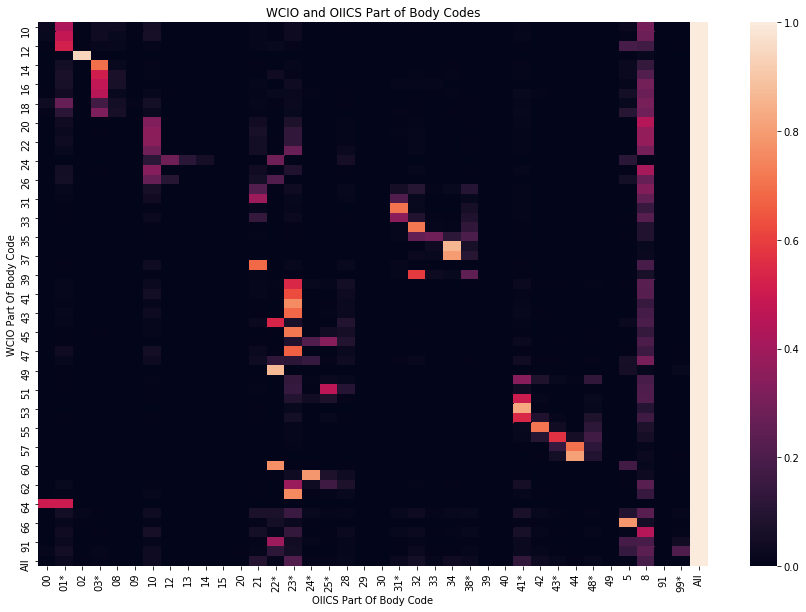

In [10]:
plt.figure(figsize=(15,10))
sns.heatmap(pd.crosstab(df['WCIO Part Of Body Code'],df['OIICS Part Of Body Code'], 
                        margins=True).apply(percConvert, axis=1))
plt.title('WCIO and OIICS Part of Body Codes')
plt.show()

The OIICS Part of Body Code 8 indicates multiple body parts. 23* is back includeing spine.  These two fields are nearly the same thing, but aren't always reported the exact same way. 

#### WCIO vs OIICS Nature of Injury Codes

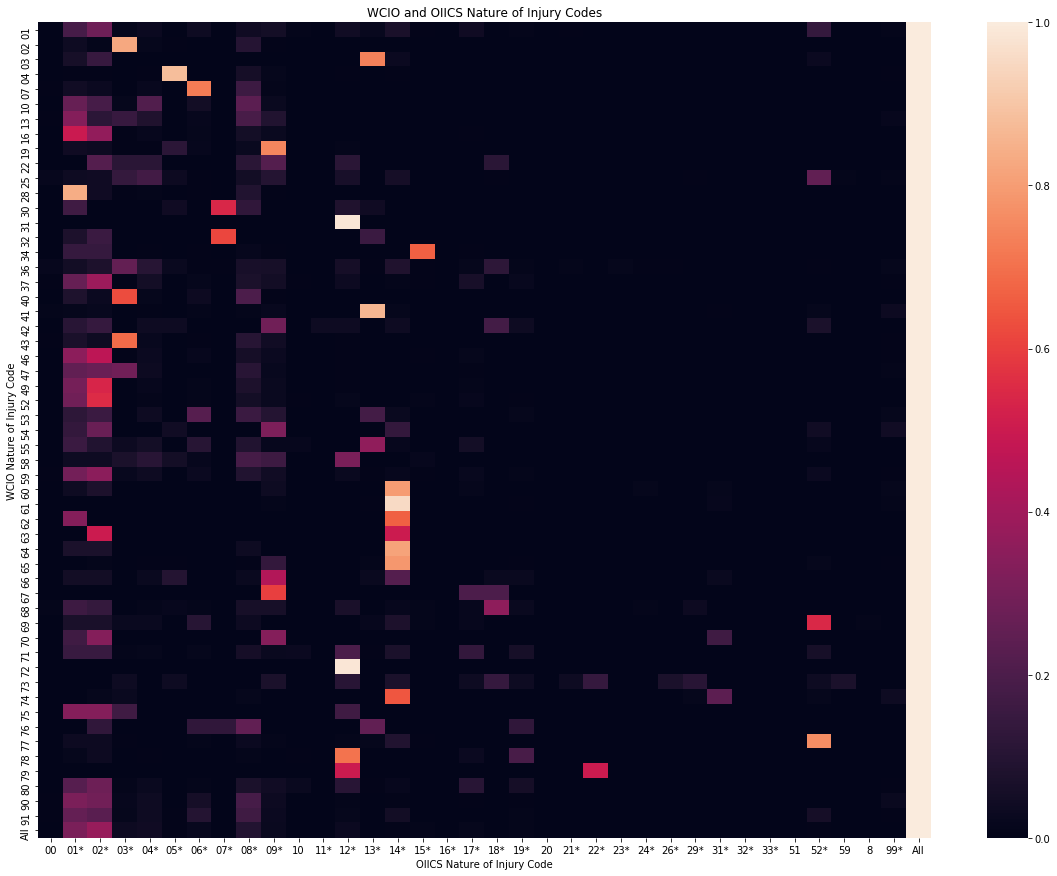

In [11]:
plt.figure(figsize=(20,15))
sns.heatmap(pd.crosstab(df['WCIO Nature of Injury Code'],df['OIICS Nature of Injury Code'], 
                        margins=True).apply(percConvert, axis=1))
plt.title('WCIO and OIICS Nature of Injury Codes')
plt.show()

The OIICS code 01* and 02* are:	01* : Traumatic injuries to bones, nerves, spinal cord,	02* : Traumatic injuries to muscles, tendons, ligaments, joints, etc.

#### WCIO And OIICS Cause of Injury Codes

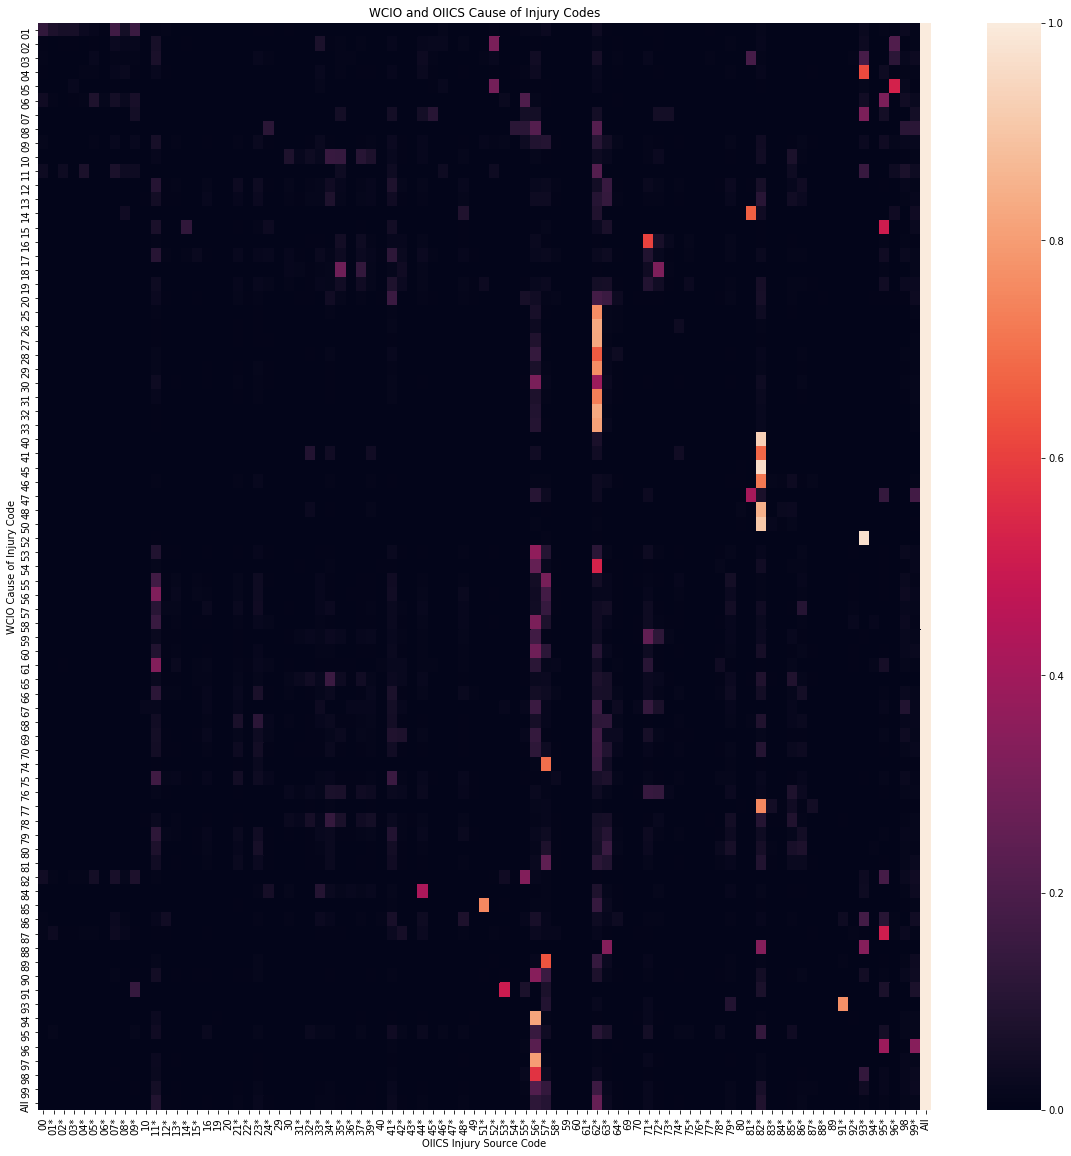

In [12]:
plt.figure(figsize=(20,20))
sns.heatmap(pd.crosstab(df['WCIO Cause of Injury Code'],df['OIICS Injury Source Code'],
                       margins=True).apply(percConvert, axis=1))

plt.title('WCIO and OIICS Cause of Injury Codes')
plt.show()

OIICS codes: 62* : Floors, walkways, ground surfaces, 56* : Person--injured or ill worker, 82* : Highway vehicle, motorized

### OIICS and WCIO codes are not the same
Take away from OIICS codes and WCIO codes, they are related, but there is also not a 1:1 correlation between most of them. However, more of the WCIO code fields are filled out than the OIICS fields.  As a result, for initial modeling the WCIO code fields will be used instead of the OIICS fields.  

### Relation Between WCIO Codes and Controverted
Next I wanted to look at whether there is any relation between codes and whether or not the claim is controverted by the insurance company.  First I looked at the WCIO Body Part codes.  Heart and Ear injuries have the highest rate of being controverted.  Fingers, eyes, and great toe injuries have some of the lowest rates of being controverted by the insurance company.  

The causes of injury with the highest rates of being controverted by the insurance companies are terrorism and continual noise.  

The nature of injury with the highest rates of being controverted is asbestosis from asbestos exposure.  This is probably much harder to prove than a puncture wound, which has a much lower rate of being controverted.   

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


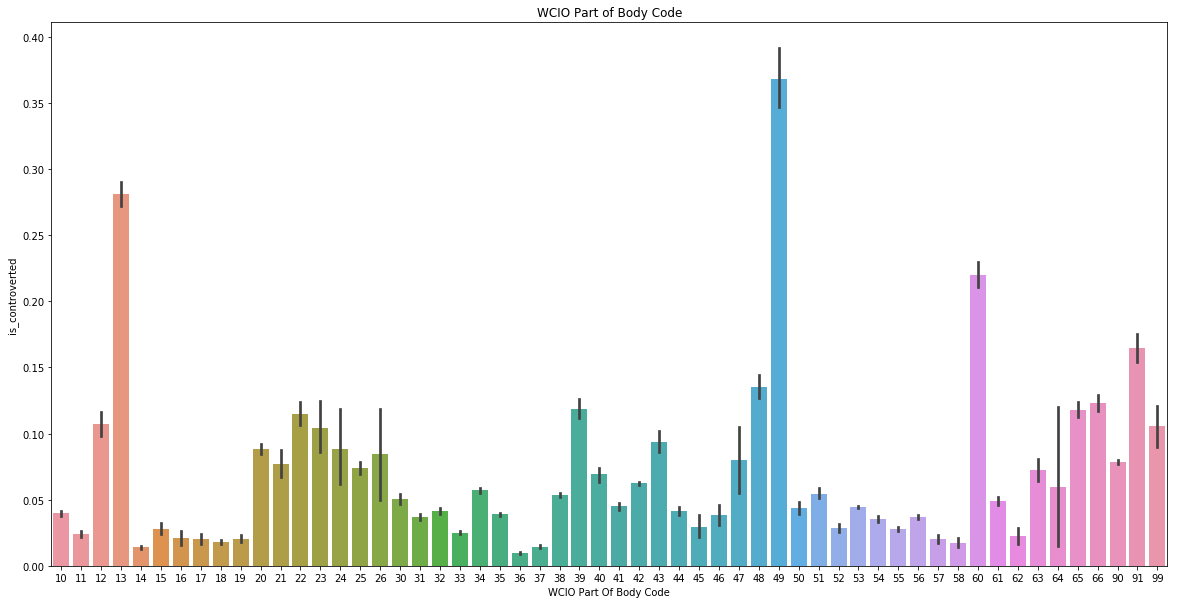

In [13]:
plt.figure(figsize=(20, 10))
sns.barplot(x='WCIO Part Of Body Code', y='is_controverted', data=df)
plt.title('WCIO Part of Body Code')
plt.show()

Code 13: Ears, Code 49: Heart, Code 60: Lungs, Code 91: BODY SYSTEMS AND MULTIPLE BODY SYSTEMS, Code 36: Fingers, Code 14: Eyes, Code 58: Great Toe

## Calculate the Binomial Error bars for the top 3

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


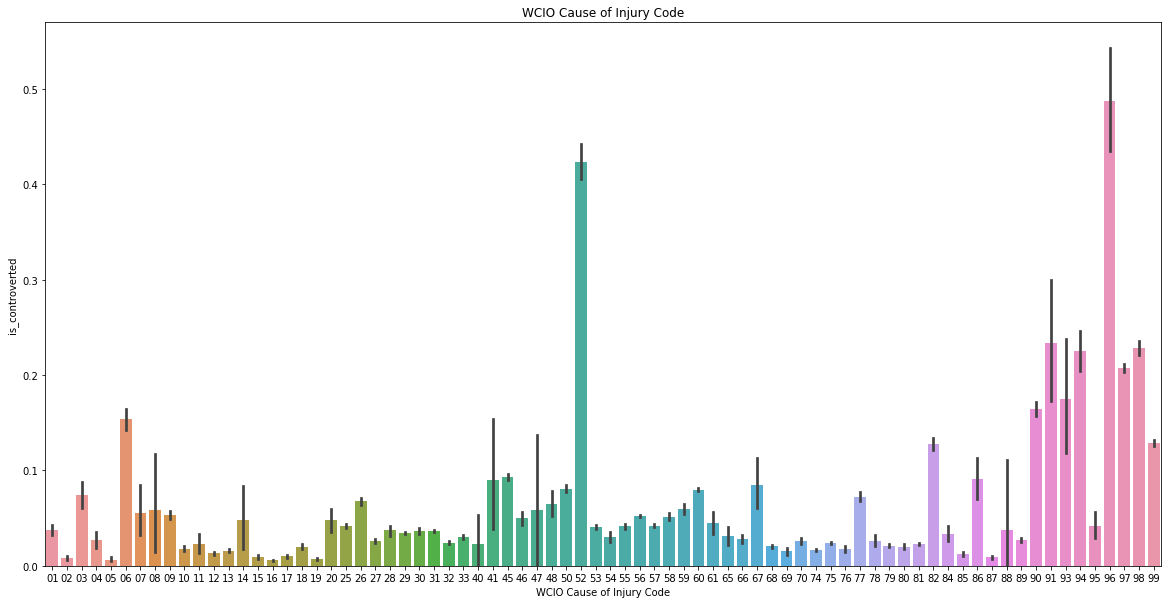

In [14]:
plt.figure(figsize=(20, 10))
sns.barplot(x='WCIO Cause of Injury Code', y='is_controverted', data=df)
plt.title('WCIO Cause of Injury Code')
plt.show()

52: Continual Noise, 96: Terrorism, 91: Mold, 94: Repetitive Motion, 98: Cumulative, no other code, 97: Repetitive motion (2 of these?), 2: Amputation, 5: 

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


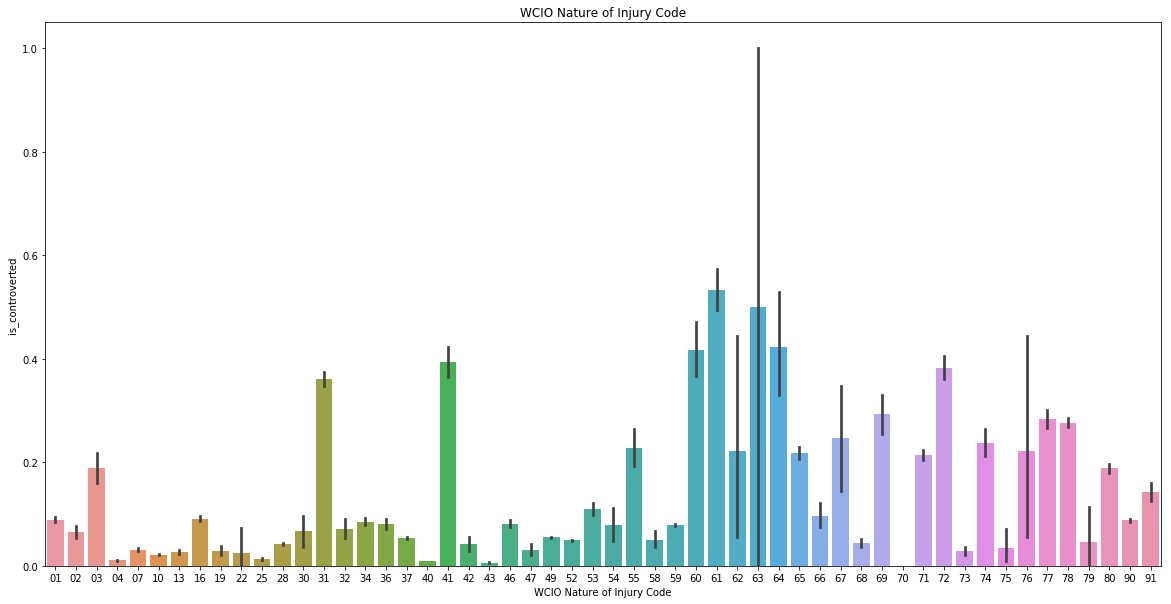

In [15]:
plt.figure(figsize=(20, 10))
sns.barplot(x='WCIO Nature of Injury Code', y='is_controverted', data=df)
plt.title('WCIO Nature of Injury Code')
plt.show()

61:  Asbestosis, 43: Puncture, 40: Laceration, 4: Burn,  

#### Commonly Injured Body Parts
Next I wanted to see which body parts are most commonly reported as injured in the claims.  This is in part to see if the most commonly injured are also the most controverted or the least.  Backs and knees are the most common reported injuries, but are not the most commonly (or least commonly) controverted.  This means that frequency is of type of injury is not the determing factor for whether or not a claim is controverted.

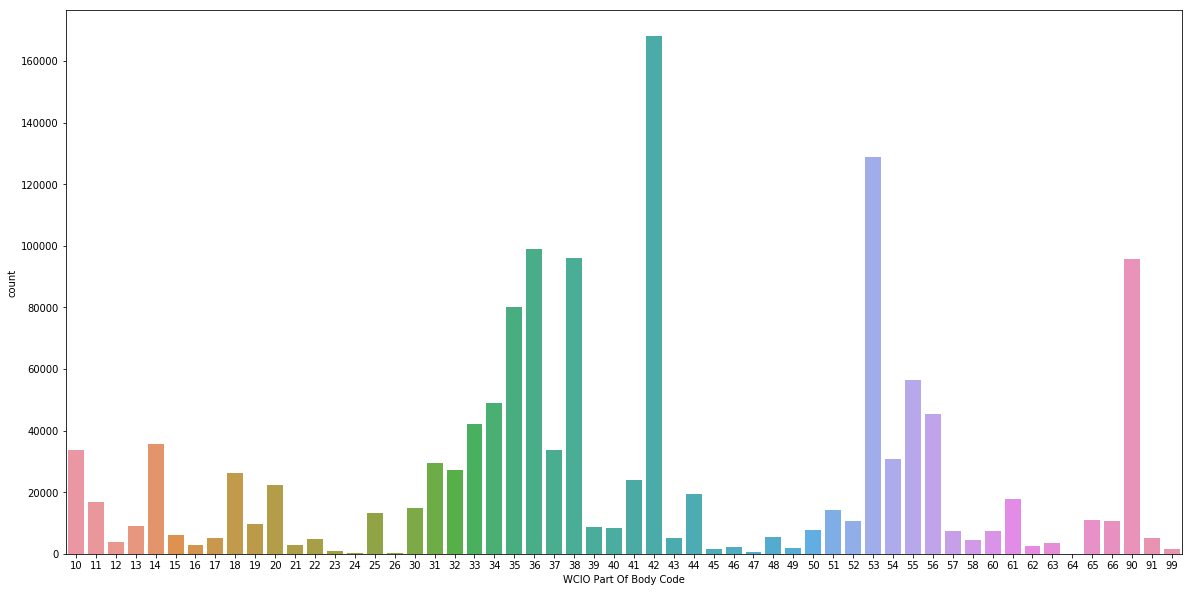

In [16]:
# Checking to see which injuries are the most common, are they also the most commonly protested?
plt.figure(figsize=(20, 10))
sns.countplot(x='WCIO Part Of Body Code', data=df)

42: Lower Back, 53: Knee, 90: Multiple parts - These are not the same ones that are most frequently protested by insurance companies

The following heatmap looks at whether a specific body part is most likely to always be injured the same way. If the WCIO Part of Body Code and WCIO Cause of Injury Code are perfectly related, then one would need to be dropped in the modeling.  On the following heatmap, the percent of a WCIO Body Code mapped to an individual WCIO Cause of Injury code is mapped.  Here it can be seen that there are different causes of injury for every body part.  This means that both could be considered when modeling.

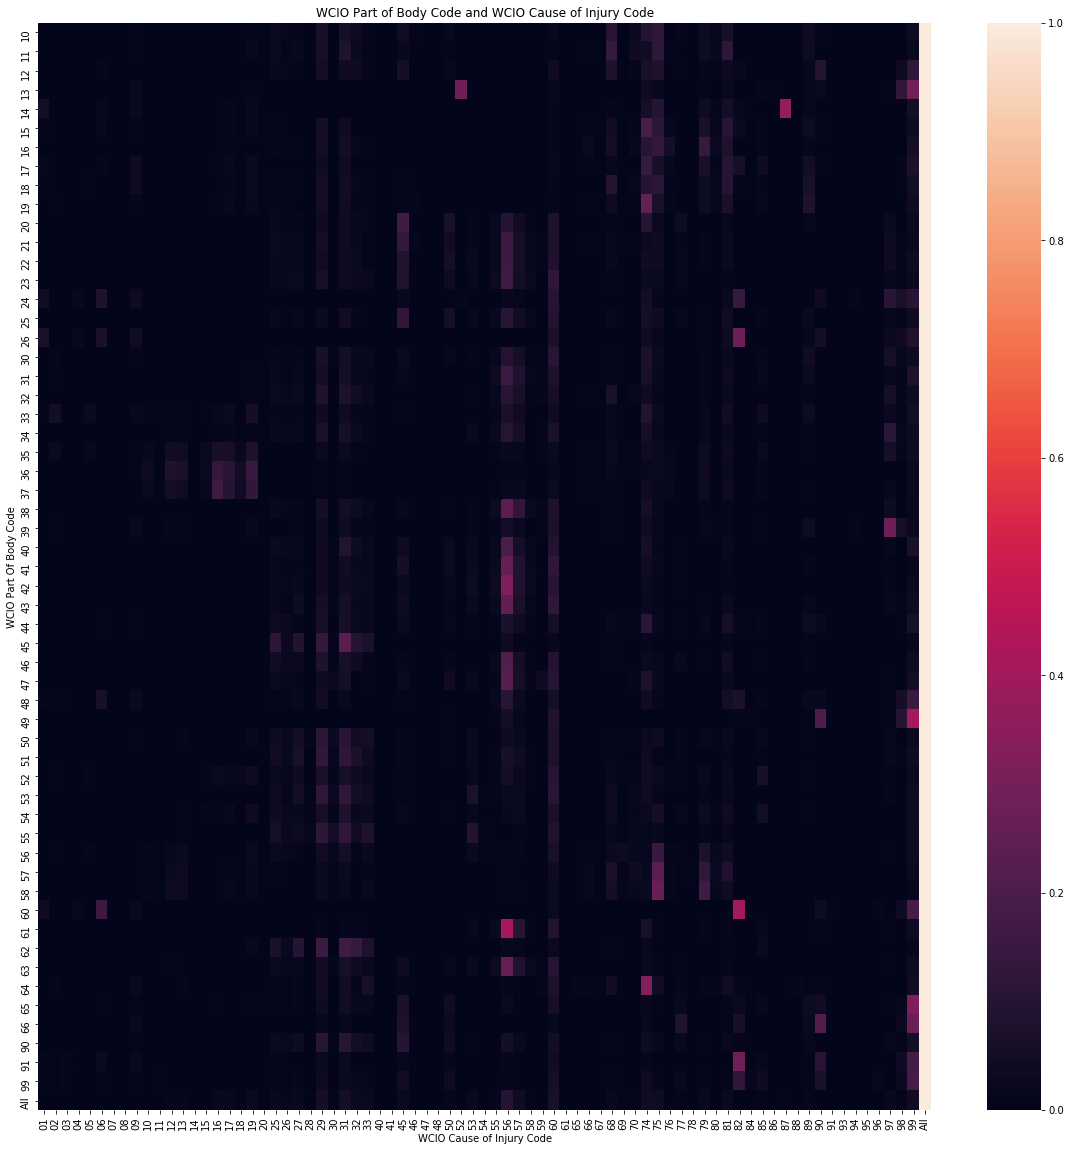

In [17]:
plt.figure(figsize=(20,20))
sns.heatmap(pd.crosstab(df['WCIO Part Of Body Code'],df['WCIO Cause of Injury Code'],
                       margins=True).apply(percConvert, axis=1))
plt.title('WCIO Part of Body Code and WCIO Cause of Injury Code')
plt.show()

The body part injured and cause of injury are related, but not 1:1. Should consider keeping both for modeling.

##  Demographics

### Gender, Wages, and Controverted

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


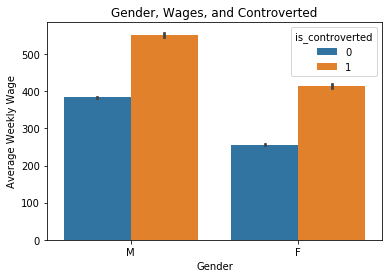

In [21]:
sns.barplot(x='Gender', y='Average Weekly Wage', hue='is_controverted', data=df)
plt.title('Gender, Wages, and Controverted')
plt.show()

This bar graph shows that the average weekly wage is higher for claims that are controverted for both males and females than on claims that are not controverted.  In addition, the average wage for males appears higher than that for females.  

# Throw in some statistics about salary and controverted claims

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


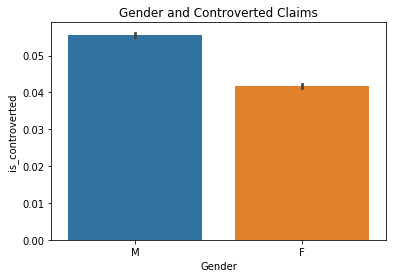

In [24]:
sns.barplot(x='Gender', y='is_controverted', data=df)
plt.title('Gender and Controverted Claims')
plt.show()

Interesting, it appears that more cases from men are disputed than from women.

#### Age and Injury

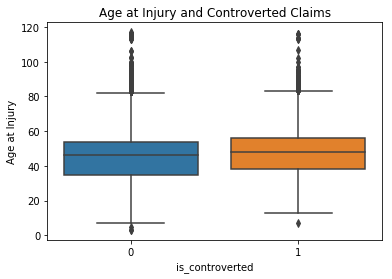

In [25]:
sns.boxplot(x='is_controverted', y='Age at Injury', data=df[df['Age at Injury'] > 1])
plt.title('Age at Injury and Controverted Claims')
plt.show()

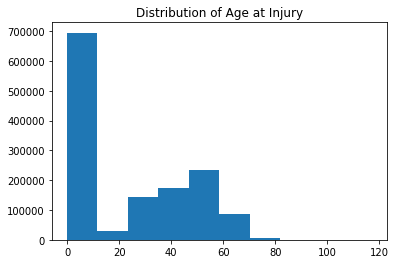

In [27]:
# Plot the distribution of ages
plt.hist(df['Age at Injury'])
plt.title('Distribution of Age at Injury')
plt.show()

From these two graphs we can see that more data points than not have the age at injury filled out as '0'.  Since this is not a realistic age for people at work, and the quantity of data points with this as a value, this category will not be used in the analysis.  The box plot above shows that for individuals with age at injury filled out, the mean age does not appear to be very different between claims that are controverted and claims that are not.  This is another justification for not using this feature for modeling.

Average Weekly Salary

Not Controverted: 328.450522
Controverted: 502.524514


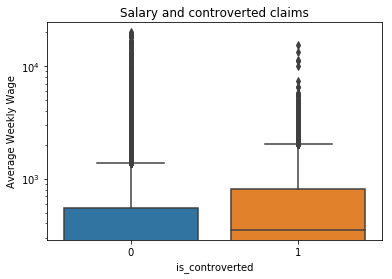

In [28]:
g = sns.boxplot(x='is_controverted', y='Average Weekly Wage', data=df)
g.set_yscale('log')
plt.title('Salary and controverted claims')

print('Average Weekly Salary\n')
print('Not Controverted: {:2f}'.format(df[df['is_controverted'] == 0]['Average Weekly Wage'].mean()))
print('Controverted: {:2f}'.format(df[df['is_controverted'] == 1]['Average Weekly Wage'].mean()))

The average weekly salary is higher for controverted claims, but there is a large weekly salary range for both categories.

### New York State Regions and Controverted Claims

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


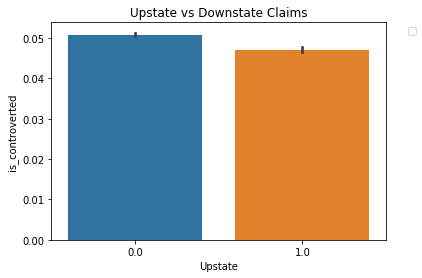

In [30]:
# Look at whether or not certain regions of New York have more claimes rejected
sns.barplot(x='Upstate', y='is_controverted', data=df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.title('Upstate vs Downstate Claims')
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


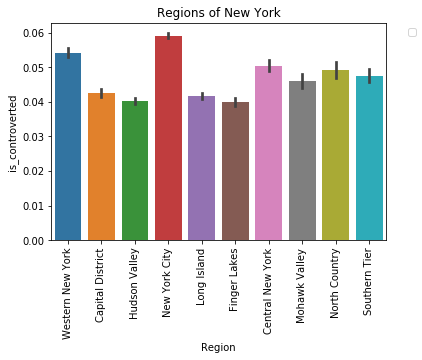

In [31]:
sns.barplot(x='Region', y='is_controverted', data=df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.xticks(rotation=90)
plt.title('Regions of New York')
plt.show()

In [ ]:
# Check the z_test value for a specific column value
#https://www.statisticshowto.datasciencecentral.com/z-test/
def z_test(df, column, value):
    n = df.shape[0]
    n_val = df[df[column] == value].shape[0]
    proportion_val = df[df[column] == value]['is_controverted'].sum()/n_val
    n_others = n - n_val
    proportion_others = df[df[column] != value]['is_controverted'].sum()/n_others
    proportion_pop = df['is_controverted'].sum()/df.shape[0]
    
    z = (proportion_val - proportion_others) / np.sqrt(proportion_pop * (1-proportion_pop) *
                                                      (1/n_val + 1/n_others))

    return z

check = z_test(df, 'Region', 'New York City')
print(check)

check2 = z_test(df, 'Assembly Month', 'January')
print(check)

From these two plots we can see that there is an effect from the region of the state the claim occurred in. Upstate has a lower rate of controverted claims.  New York City (down state) has the hightest rate.

## Timing

(-50, 700)

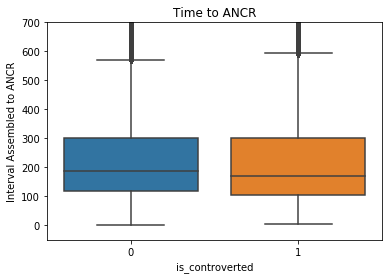

In [32]:
# This is a measure of how long it takes for the WCB board to consider the paperwork complete
# Does not appear to have much of a difference between controverted and not.

g = sns.boxplot(x='is_controverted', y='Interval Assembled to ANCR', data=df)
plt.title('Time to ANCR')
plt.ylim(-50, 700)


In [33]:
df['Accident Year'] = df['Accident Date'].dt.year
df['Accident Month'] = df['Accident Date'].dt.month
df['Accident Day'] = df['Accident Date'].dt.dayofweek

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


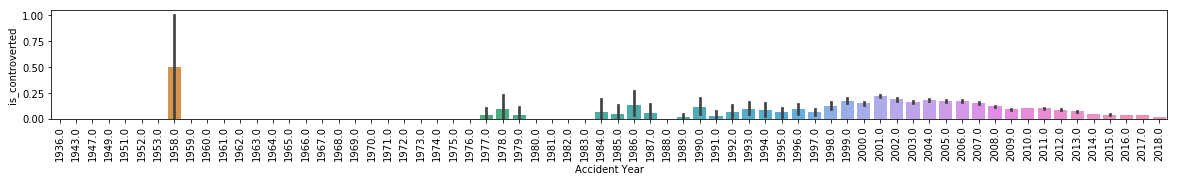

In [34]:
plt.figure(figsize=(20, 2))
sns.barplot(x='Accident Year', y='is_controverted', data=df)
plt.xticks(rotation=90)
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


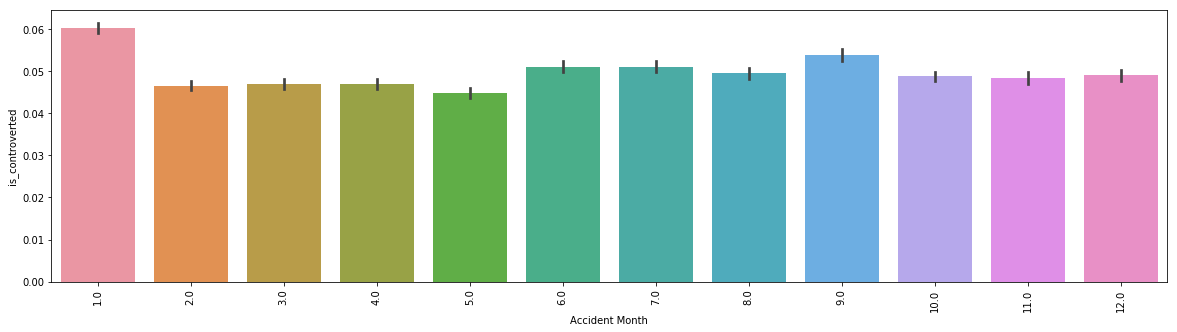

In [35]:
plt.figure(figsize=(20, 5))
sns.barplot(x='Accident Month', y='is_controverted', data=df)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Two proportions z-test looking at January vs the rest of the months
#https://www.statisticshowto.datasciencecentral.com/z-test/

n_jan = df[df['Accident Month'] == 1].shape[0]

proportion_jan = df[df['Accident Month'] == 1]['is_controverted'].sum()/n_jan
    
n_others = df[df['Accident Month'] != 1].shape[0]  
    
proportion_others = df[df['Accident Month'] != 1]['is_controverted'].sum()/n_others
    
pop_proportion = df['is_controverted'].sum() / df.shape[0]

z = (proportion_jan - proportion_others) /
    np.sqrt(pop_proportion *(1-pop_proportion)*(1/n_jan + 1/n_others))
    


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


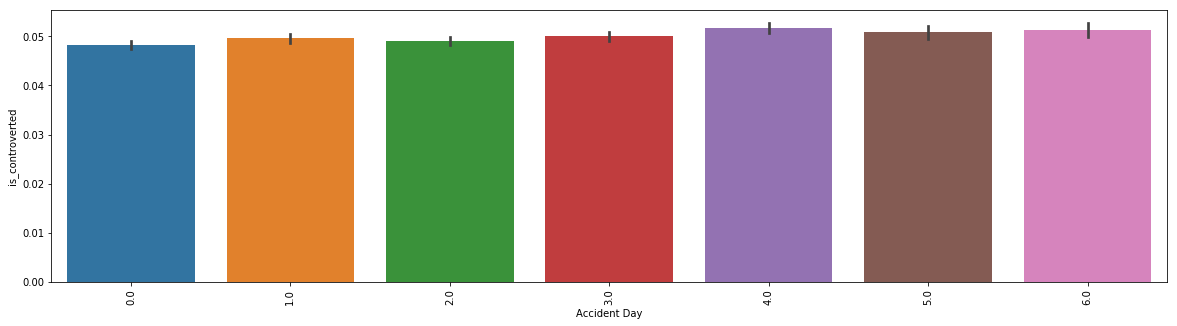

In [36]:
# Monday is 0, Sunday is 6
plt.figure(figsize=(20, 5))
sns.barplot(x='Accident Day', y='is_controverted', data=df)
plt.xticks(rotation=90)
plt.show()

In [37]:
df['Assembly Year'] = df['Assembly Date'].dt.year
df['Assembly Month'] = df['Assembly Date'].dt.month
df['Assembly Day'] = df['Assembly Date'].dt.dayofweek

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


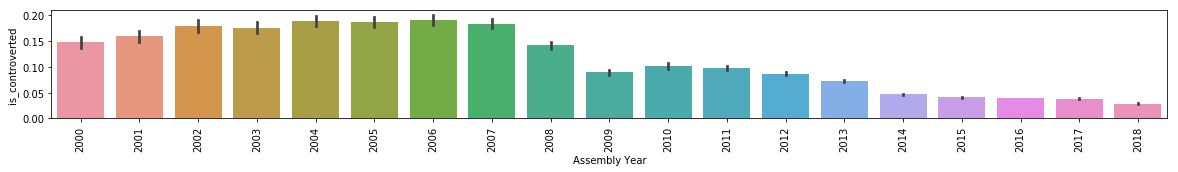

In [38]:
plt.figure(figsize=(20, 2))
sns.barplot(x='Assembly Year', y='is_controverted', data=df)
plt.xticks(rotation=90)
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


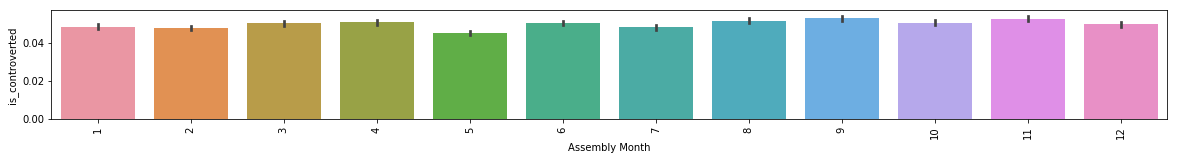

In [39]:
plt.figure(figsize=(20, 2))
sns.barplot(x='Assembly Month', y='is_controverted', data=df)
plt.xticks(rotation=90)
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


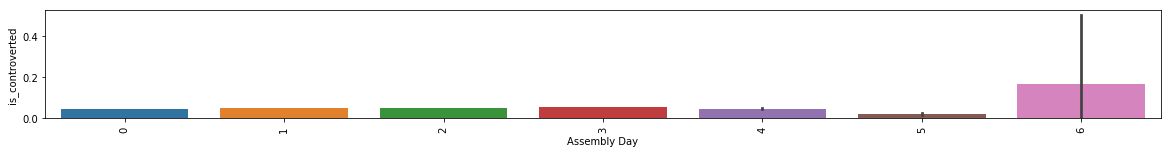

In [40]:
# This state employees are unlikely to be working on weekends (5 or 6)
plt.figure(figsize=(20, 2))
sns.barplot(x='Assembly Day', y='is_controverted', data=df)
plt.xticks(rotation=90)
plt.show()

## Looking at the insurance carriers

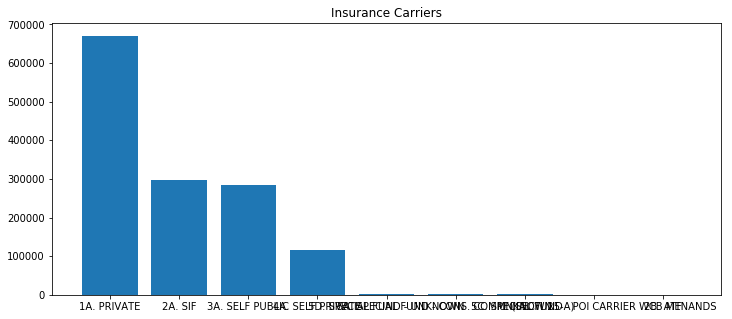

In [41]:
ins_types_plot = df.groupby(by='Carrier Type')['Carrier Type'].count()
ins_types_plot = ins_types_plot.sort_values(ascending=False)
plt.figure(figsize=(12, 5))
plt.bar(ins_types_plot.index, ins_types_plot)
plt.title('Insurance Carrier Type')

plt.show()

There are 1465 different insurance carriers.
State Insurance Fund is the largest carrier


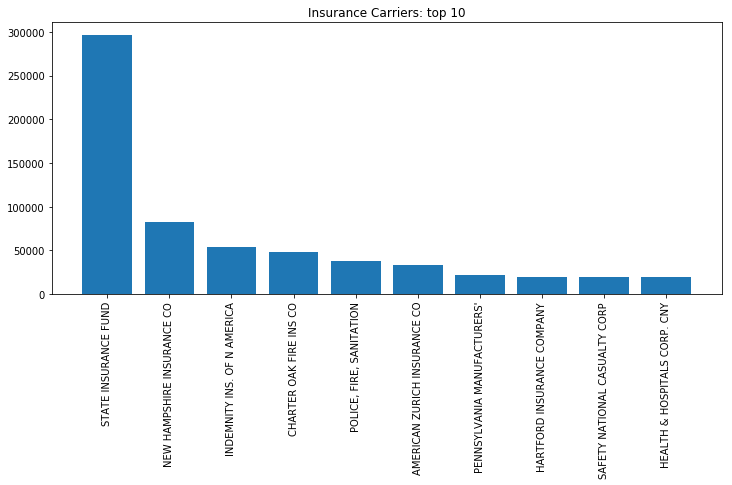

In [42]:
carrier_plot = df.groupby(by='Carrier Name')['Carrier Name'].count()
carrier_plot = carrier_plot.sort_values(ascending=False)[:10]
plt.figure(figsize=(12, 5))
plt.bar(carrier_plot.index, carrier_plot)
plt.xticks(rotation=90)
plt.title('Insurance Carriers: top 10')

print('There are {} different insurance carriers.'.format(len(df['Carrier Name'].unique())))
print('State Insurance Fund is the largest carrier')
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

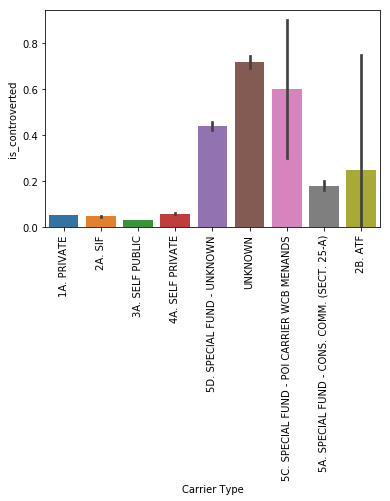

In [43]:
sns.barplot(x='Carrier Type', y='is_controverted', data=df)
plt.xticks(rotation=90)

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(pd.crosstab(df['Medical Fee Region'],df['Regions'], 
                        margins=True).apply(percConvert, axis=1))
plt.title('Medical Fee Regions and Regions')
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


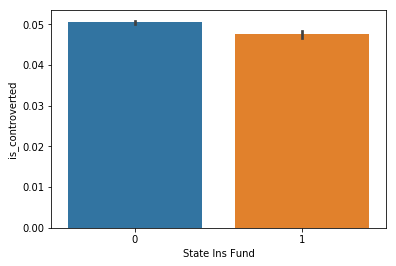

In [44]:
# Look at whether or not the state insurance fund has a higher/lower rate
# of controverted claims
sns.barplot(x='State Ins Fund', y='is_controverted', data=df)
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


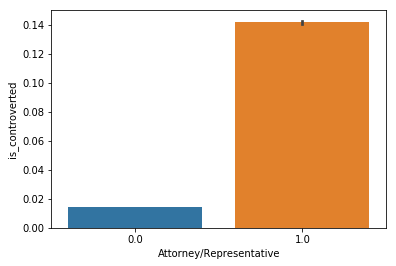

In [45]:
# Look at whether or not the state insurance fund has a higher/lower rate
# of controverted claims
sns.barplot(x='Attorney/Representative', y='is_controverted', data=df)
plt.show()

Most likely you get an attorney if you know your case is complicated, or maybe after it has already been controverted. No need for an attorney if the case is smooth.

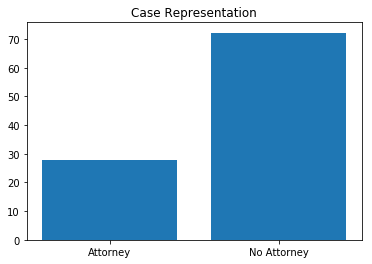

In [46]:
# Cases that are represented
perc_attorney = df['Attorney/Representative'].sum() / len(df['Attorney/Representative']) * 100
perc_none = 100 - perc_attorney
plt.bar(['Attorney','No Attorney'], [perc_attorney, perc_none])
plt.title('Case Representation')
plt.show()

In [49]:
features = ['Average Weekly Wage', 'Region', 'WCIO Part Of Body Code',
       'WCIO Nature of Injury Code', 'WCIO Cause of Injury Code', 
       'GenderNum', 'MedRegion1', 'MedRegion2', 'MedRegion3', 'MedRegion4', 
       'Assembly Year', 'Assembly Month', 'Assembly Day', 'State Ins Fund', 'is_controverted']

## Model 1: Did not undersample the majority class

In [70]:
df_model = df[features].dropna(axis=0)
X = df_model[features].drop('is_controverted', axis=1)
y = df_model['is_controverted']

le = LabelEncoder()
X['Region'] = le.fit_transform(X['Region'])
X['WCIO Part Of Body Code'] = le.fit_transform(X['WCIO Part Of Body Code'])
X['WCIO Cause of Injury Code'] = le.fit_transform(X['WCIO Cause of Injury Code']) 
X['WCIO Nature of Injury Code'] = le.fit_transform(X['WCIO Nature of Injury Code'])


X.head()


,Average Weekly Wage,Region,WCIO Part Of Body Code,WCIO Nature of Injury Code,WCIO Cause of Injury Code,GenderNum,MedRegion1,MedRegion2,MedRegion3,MedRegion4,Assembly Year,Assembly Month,Assembly Day,State Ins Fund
0,610.00,9,29,30,53,1.0,0,1,0,0,2015,6,1,0
1,215.88,0,10,25,53,0.0,0,1,0,0,2015,7,4,1
2,530.72,3,29,25,39,0.0,0,0,1,0,2015,7,0,1
3,609.08,6,29,30,75,1.0,0,0,0,1,2015,7,4,0
4,400.00,4,29,25,40,0.0,0,0,0,1,2015,7,4,0


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [72]:
print(rfc.score(X_test, y_test))
y_pred = rfc.predict(X_test)
confusion_matrix(y_test, y_pred)

0.9495339472482497


array([[387671,   1562],
       [ 19104,   1166]])

## Undersampling Majority Class

In [62]:
# Find number of data points of controverted claims
# This works because a controverted data point is 1, normal is 0
num_controverted = df_model['is_controverted'].sum()

# Randomly select the same number of normal records
rand_normal = df_model[df_model['is_controverted']==0].sample(num_controverted)

# Combine data
df_under = pd.concat([df_model[df_model['is_controverted']==1], rand_normal])

# Show the ratio
print('Percent Controverted = {}'.format(df_under['is_controverted'].sum()/len(df_under['is_controverted'])))

Percent Controverted = 0.5


In [162]:
X = df_model[features]


le = LabelEncoder()
X['Region'] = le.fit_transform(X['Region'])
X['WCIO Part Of Body Code'] = le.fit_transform(X['WCIO Part Of Body Code'])
X['WCIO Cause of Injury Code'] = le.fit_transform(X['WCIO Cause of Injury Code']) 
X['WCIO Nature of Injury Code'] = le.fit_transform(X['WCIO Nature of Injury Code'])

train, test = train_test_split(X, test_size=0.3)

num_controverted = train['is_controverted'].sum()

train_controverted = train[train['is_controverted'] == 1]
rand_not_controverted = train[train['is_controverted'] == 0].sample(num_controverted)

# Combine data
train_under = pd.concat([train[train['is_controverted'] == 1], rand_not_controverted])

# Show the ratio
print('Percent Controverted = {}'.format(train_under['is_controverted'].sum()/len(train_under['is_controverted'])))

X_train_under = train.drop('is_controverted', axis=1)
y_train_under = train['is_controverted']
X_test = test.drop('is_controverted', axis=1)
y_test = test['is_controverted']

Percent Controverted = 0.5


In [85]:
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(X_train_under, y_train_under)
y_pred = rfc.predict(X_test)
rfc.score(X_test, y_test)

0.9499759464521628

In [86]:
# Look at the confusion matrix for the test data points
confusion_matrix(y_test, y_pred)

array([[387782,   1498],
       [ 18987,   1236]])

In [88]:
# Look at the score for the training under sampled data
y_train_under_pred = rfc.predict(X_train_under)
print(rfc.score(X_train_under, y_train_under))
print(confusion_matrix(y_train_under, y_train_under_pred))


0.997027755945273
[[907932    302]
 [  2538  44735]]


## Try one-hot encoding 

In [154]:
# Categorical features that need to be one hot encoded
cat_features = ['Region', 'WCIO Part Of Body Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code']

# Use pd.get dummies to one hot encode
one_hot = pd.get_dummies(df_model[cat_features])


# List of featurest that are not one hot encoded by this
features_not_one_hot = ['Average Weekly Wage', 'GenderNum', 'MedRegion1', 'MedRegion2', 'MedRegion3', 'MedRegion4', 
                        'Assembly Year', 'Assembly Month', 'Assembly Day', 'State Ins Fund', 'is_controverted']
# Join the one hot encoded features back to the other variables
df_enc = df_model[features_not_one_hot].join(one_hot)
df_enc.head()

# Split train and test data
train, test = train_test_split(df_enc, test_size=0.3)

# Total number of controverted claims in the training data set
num_controverted = train['is_controverted'].sum()

# Select all the controverted claims, and equal number of not controverted ones
# This undersamples the majority class
train_controverted = train[train['is_controverted'] == 1]
rand_not_controverted = train[train['is_controverted'] == 0].sample(num_controverted)

# Combine data
train_under = pd.concat([train[train['is_controverted'] == 1], rand_not_controverted])

# Show the ratio
print('Percent Controverted = {}'.format(train_under['is_controverted'].sum()/
                                         len(train_under['is_controverted'])))

# Create under sampling training datasets
# Test data sets have original proportion of controverted/not-controverted claims
X_train_under = train.drop('is_controverted', axis=1)
y_train_under = train['is_controverted']
X_test = test.drop('is_controverted', axis=1)
y_test = test['is_controverted']

# Train random forest classifier on under-sampled data
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(X_train_under, y_train_under)
# Predict on full test set
y_pred = rfc.predict(X_test)
print('Random Forest one hot encoded score\n')
print(rfc.score(X_test, y_test))



Percent Controverted = 0.5


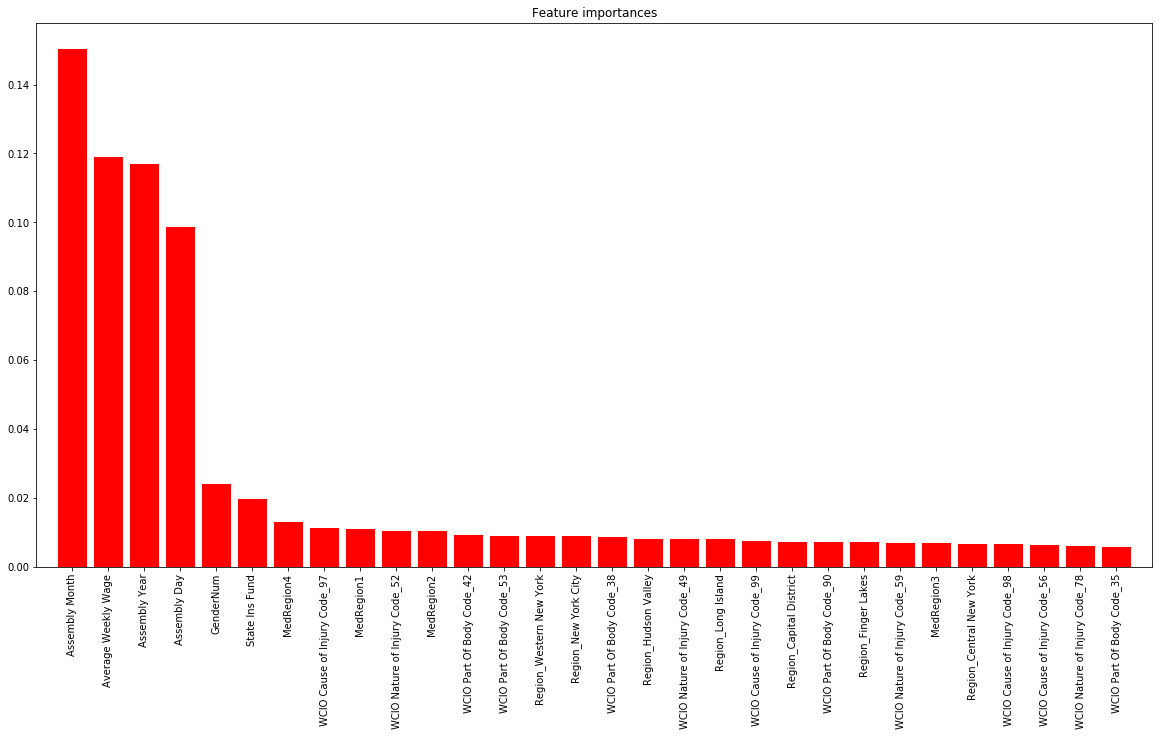

In [156]:
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(30), importances[indices][:30], color="r", align="center")
plt.xticks(range(30), X_train_under.columns[indices][:30], rotation=90)
plt.xlim([-1, 30])
plt.show()

In [158]:
# Look at the confusion matrix for the test data points
print('The confusion matrix for the test set one hot encoded random forest')
print(confusion_matrix(y_test, y_pred))

# Look at the score for the training under sampled data
y_train_under_pred = rfc.predict(X_train_under)
print('\nThe score for the under sampled training set.')
print(rfc.score(X_train_under, y_train_under))
print('\nThe confusion matrix for the under sampled training set')
print(confusion_matrix(y_train_under, y_train_under_pred))

# Precision and recall metrics for the test set
print('\nThe precision of this model is: {:2f}'.format(precision_score(y_test, y_pred))
print('\nThe recall score of this model is: {:2f}'.format(recall_score(y_test, y_pred)))


[[387673   1721]
 [ 18841   1268]]
0.9969408910662089
[[907804    316]
 [  2607  44780]]
The precision of this model is:
0.4242221478755437
The recall score of this model is:
0.06305634293102591


### Random Forest + Grid Search

In [ ]:
param_grid = {'n_estimators': np.arange(10, 500, 50),
              'criterion': ['gini', 'entropy'],
              'min_samples_split': np.arange(2, 10, 2)}

clf = GridSearchCV(rfc, param_grid, cv=5)
clf.fit(X_train_under, y_train_under)

clf.best_params_

Slightly better without one hot encoding

## Logistic Regression 

Try lasso regression due to the number of features.  

In [148]:
lr = LogisticRegression(penalty='l2', solver='liblinear')
lr.fit(X_train_under, y_train_under)
y_pred = lr.predict(X_test)
print(lr.score(X_test, y_test))
print(confusion_matrix(y_test, y_pred))

print(lr.score(X_train_under, y_train_under))

0.9507695914315646
[[389211    163]
 [ 19997    132]]
0.9504577151187799


Although the score is higher for this model, it achieved this by classifying nearly all points as non-controverted claims. The precision and recall on this model are poor. 

In [149]:
precision_score(y_test, y_pred)

0.44745762711864406

In [150]:
# Recall = true positive / (true pos + false neg)
recall = (confusion_matrix(y_test, y_pred)[1][1]) / (confusion_matrix(y_test, y_pred)[1][1] 
                                                     + confusion_matrix(y_test, y_pred)[1][0])

In [151]:
print(recall)

0.006557702816831437


In [153]:
# Just checking my recall formula
recall_score(y_test, y_pred)

0.006557702816831437